<a href="https://colab.research.google.com/github/piggyatbaqaqi/sugarbowl/blob/main/sugarbowl_jj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


# Sugarbowl Exploratory page
**Syracuse University IST736 Summer 2025 by La Monte Henry Piggy Yarroll and JJ Balasi**

# Introduction

##Data Types and Definitions

Device

Serial Number

Device Timestamp

Record Type

Historic Glucose mg/dL

Scan Glucose mg/dL


#Data Alterations

We have removed from the data set any day that the reading taken was blank.

## Data

In [54]:
!pwd

/content


In [55]:
# Load CSV
data = pd.read_csv("La_Monte_Yarroll_glucose_7-20-2025.csv", header=1)


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124907 entries, 0 to 124906
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Device                            124907 non-null  object 
 1   Serial Number                     124907 non-null  object 
 2   Device Timestamp                  124907 non-null  object 
 3   Record Type                       124907 non-null  int64  
 4   Historic Glucose mg/dL            106874 non-null  float64
 5   Scan Glucose mg/dL                12610 non-null   float64
 6   Non-numeric Rapid-Acting Insulin  0 non-null       float64
 7   Rapid-Acting Insulin (units)      0 non-null       float64
 8   Non-numeric Food                  0 non-null       float64
 9   Carbohydrates (grams)             50 non-null      float64
 10  Carbohydrates (servings)          0 non-null       float64
 11  Non-numeric Long-Acting Insulin   0 non-null       f

In [57]:
time_format = '%m-%d-%Y %H:%M %p'
data.loc[:, 'timestamp'] = data['Device Timestamp'].map(lambda t: datetime.strptime(t, time_format))
data.sort_values(by='timestamp', ascending=True, inplace=True)

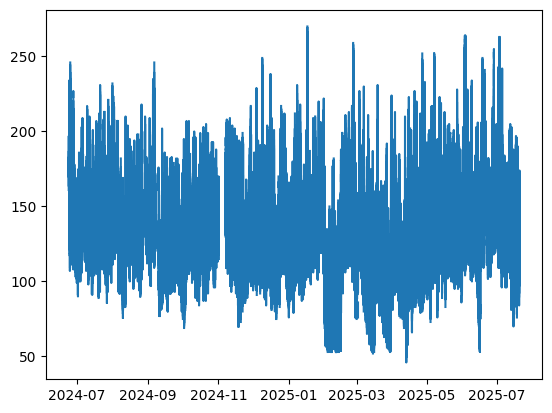

In [58]:
plt.plot(data['timestamp'], data['Historic Glucose mg/dL'])
plt.show()

In [59]:
data['Serial Number'].value_counts()

,count
Serial Number,
0e154b86-bf50-4004-9ddb-123beeb2e7c4,124900
22c6a4d9-071c-476f-b04b-3d6ea3761356,6
a67a800c-57e1-46c9-b156-804a3a3f702a,1


In [60]:
# Define potential glucose columns and keep only those that exist
glucose_columns = [col for col in ['Scan Glucose mg/dL', 'Historic Glucose mg/dL', 'Strip Glucose mg/dL'] if col in data.columns]


In [61]:
# Use backfill to combine available glucose readings
data['Glucose Value'] = data[glucose_columns].bfill(axis=1).iloc[:, 0]
df_glucose = data.dropna(subset=['Glucose Value']).copy()
df_glucose['Glucose Value'] = pd.to_numeric(df_glucose['Glucose Value'], errors='coerce')


In [62]:
# Categorize glucose levels
def categorize_glucose(value):
    if value < 70:
        return 'Low'
    elif value > 180:
        return 'High'
    else:
        return 'Normal'

df_glucose['Glucose Category'] = df_glucose['Glucose Value'].apply(categorize_glucose)


In [63]:
#Keyword tagging on Notes
keywords = {
    'low': ['low', 'dizzy', 'shaky', 'sweaty', 'hypo', 'lightheaded'],
    'high': ['high', 'hyper', 'thirsty', 'dry mouth', 'blurry', 'tired'],
    'meal': ['ate', 'meal', 'breakfast', 'lunch', 'dinner', 'snack'],
    'exercise': ['exercise', 'walk', 'ran', 'gym', 'workout', 'biked'],
    'sick': ['sick', 'nausea', 'vomit', 'cold', 'flu', 'infection'],
}

In [64]:

def tag_note_category(note):
    note = str(note).lower()
    tags = []
    for category, words in keywords.items():
        if any(word in note for word in words):
            tags.append(category)
    return ', '.join(tags) if tags else 'other'

df_notes = df_glucose.dropna(subset=['Notes']).copy()
df_notes['Note Tags'] = df_notes['Notes'].apply(tag_note_category)


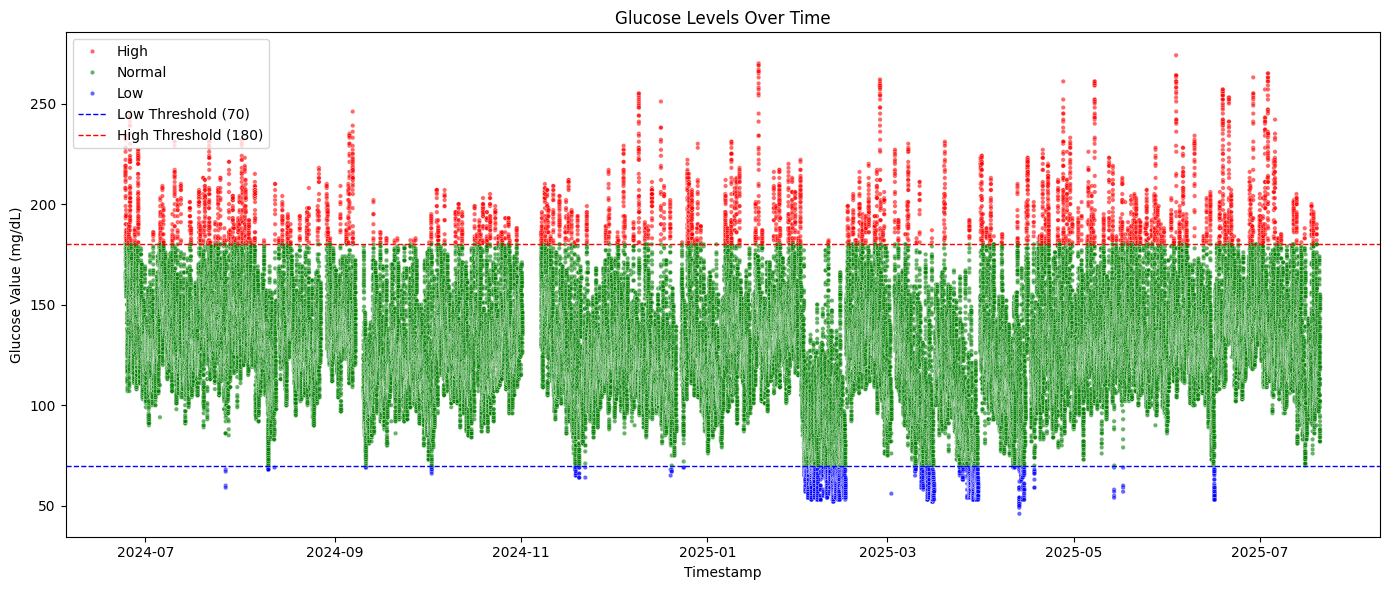

In [65]:

# Plotting Glucose Trends
df_glucose['Device Timestamp'] = pd.to_datetime(df_glucose['Device Timestamp'], errors='coerce')
df_glucose_clean = df_glucose.dropna(subset=['Device Timestamp', 'Glucose Value'])
df_glucose_clean = df_glucose_clean.sort_values(by='Device Timestamp')

plt.figure(figsize=(14, 6))
sns.scatterplot(
    data=df_glucose_clean,
    x='Device Timestamp',
    y='Glucose Value',
    hue='Glucose Category',
    palette={'Low': 'blue', 'Normal': 'green', 'High': 'red'},
    s=10,
    alpha=0.6
)
plt.axhline(70, color='blue', linestyle='--', linewidth=1, label='Low Threshold (70)')
plt.axhline(180, color='red', linestyle='--', linewidth=1, label='High Threshold (180)')
plt.title('Glucose Levels Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Glucose Value (mg/dL)')
plt.legend()
plt.tight_layout()
plt.show()


In [66]:
# ML Classification (Decision Tree + SVM)
df_ml = df_glucose_clean.dropna(subset=['Glucose Value', 'Glucose Category'])
df_ml['Glucose Category Code'] = df_ml['Glucose Category'].map({'Low': 0, 'Normal': 1, 'High': 2})
X = df_ml[['Glucose Value']]
y = df_ml['Glucose Category Code']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt.predict(X_test)))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       507
           1       1.00      1.00      1.00     22428
           2       1.00      1.00      1.00       962

    accuracy                           1.00     23897
   macro avg       1.00      1.00      1.00     23897
weighted avg       1.00      1.00      1.00     23897



In [68]:
# SVM
svm = SVC()
svm.fit(X_train, y_train)
print("\nSVM Classification Report:")
print(classification_report(y_test, svm.predict(X_test)))


SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       507
           1       1.00      1.00      1.00     22428
           2       1.00      1.00      1.00       962

    accuracy                           1.00     23897
   macro avg       1.00      1.00      1.00     23897
weighted avg       1.00      1.00      1.00     23897



In [69]:
#  Time-Series Forecasting using ARIMA
series = df_glucose_clean.set_index('Device Timestamp')['Glucose Value'].resample('H').mean().ffill()
model = ARIMA(series, order=(1,1,1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=24)
print("\nNext 24-hour forecast of glucose values:")
print(forecast)


Next 24-hour forecast of glucose values:
2025-07-20 19:00:00    135.133413
2025-07-20 20:00:00    136.525056
2025-07-20 21:00:00    136.024183
2025-07-20 22:00:00    136.204455
2025-07-20 23:00:00    136.139572
2025-07-21 00:00:00    136.162924
2025-07-21 01:00:00    136.154520
2025-07-21 02:00:00    136.157545
2025-07-21 03:00:00    136.156456
2025-07-21 04:00:00    136.156848
2025-07-21 05:00:00    136.156707
2025-07-21 06:00:00    136.156757
2025-07-21 07:00:00    136.156739
2025-07-21 08:00:00    136.156746
2025-07-21 09:00:00    136.156743
2025-07-21 10:00:00    136.156744
2025-07-21 11:00:00    136.156744
2025-07-21 12:00:00    136.156744
2025-07-21 13:00:00    136.156744
2025-07-21 14:00:00    136.156744
2025-07-21 15:00:00    136.156744
2025-07-21 16:00:00    136.156744
2025-07-21 17:00:00    136.156744
2025-07-21 18:00:00    136.156744
Freq: h, Name: predicted_mean, dtype: float64


In [70]:
# Text Clustering with TF-IDF and KMeans
if not df_notes.empty:
    tfidf = TfidfVectorizer(stop_words='english', max_features=100)
    X_text = tfidf.fit_transform(df_notes['Notes'].astype(str))
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(X_text)
    df_notes['Text Cluster'] = clusters

## Methods and Models

Algorithms Used:
- Backfill Imputation: Fills missing glucose readings from alternate sources.
- Rule-Based Classification: Categorizes glucose levels using thresholds.
- Keyword Matching: Tags notes with contextual labels based on key terms.
- Scatter Plot: Visual representation of glucose levels over time.
- Decision Tree Classifier: Predicts glucose category using glucose values.
- Support Vector Machine (SVM): Alternative classifier for glucose categories.
- ARIMA Forecasting: Predicts future glucose values using time series modeling.
- TF-IDF + KMeans: Clusters textual notes into semantic groups.

## Results and Observations

## Experimental Design and Investigation Strategy

## Conclusions

## Appendix

## Bibliography